# Forecasting Cases and Lockdowns

The aim of this project is to plan holidays and life around lockdown by predicting when NSW lockdown will cease. There is a time series dataset of [cases](https://data.nsw.gov.au/nsw-covid-19-data/cases) available through open data NSW and a website which has key [summaries of announcements](https://www.aph.gov.au/About_Parliament/Parliamentary_Departments/Parliamentary_Library/pubs/rp/rp2021/Chronologies/COVID-19StateTerritoryGovernmentAnnouncements).
<br>  
The model will predict the confidence across a range of dates, and the visible output will be a probability distribution across a 2 week period with the mid date being the most likely date.
<br>  
The model will be retrained daily, in the afternoon once the daily case data and new announcements have come in.
<br>  
The data will be available through a streamlit dashboard with the Date clearly visible and a plotly graph showing the probabilities.


Ideas:  
- probability of compliance with stay at home orders
- Map the vaccination rate and a threshold (as a param) to seeing can infer full vaccination at 6 week lag to first dose
- create a variable for the strain (delta vs ...)

Ideas:
- Look at optimal placement of vaccination centres based on population, cases, transmission rates and severe cases

In [1]:
!pip install plotly

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
  Using cached plotly-5.1.0-py2.py3-none-any.whl (20.6 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [2]:
conda install -c conda-forge nbformat

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - nbformat


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    attrs-21.2.0               |     pyhd8ed1ab_0          44 KB  conda-forge
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py36h5fab9bb_0         141 KB  conda-forge
    conda-4.10.3               |   py36h5fab9bb_0         3.1 MB  conda-forge
    importlib-metadata-4.6.3   |   py36h5fab9bb_0          31 KB  conda-forge
    jsonschema-3.2.0           |     pyhd8ed1ab_3          45 KB  conda-forge
    jupyter_core-4.7.1         |   py36h5fab9bb_0          72 KB  conda-forge
  

In [3]:
!pip install pytrends

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
  Using cached pytrends-4.7.3-py3-none-any.whl (14 kB)
  Using cached lxml-4.6.3-cp36-cp36m-manylinux2014_x86_64.whl (6.3 MB)
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


In [4]:
import requests, json, logging, errno, os
from typing import List
from datetime import datetime, timedelta
from pathlib import Path
from pprint import pprint
from functools import reduce

import pandas as pd
import numpy as np
# from prophet import? Prophet

# Vis libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

from src.dataloader import DataLoader

In [5]:
import yaml
try:
    creds = yaml.safe_load(open('credentials.yml'))
    twitter_creds = creds['twitter']

    TWITTER_API_KEY = twitter_creds['API_KEY']
    TWITTER_API_SECRET_KEY = twitter_creds['API_SECRET_KEY']
    TWITTER_BEARER_TOKEN = twitter_creds['BEARER_TOKEN']
except Exception:
    raise Exception('''If you want twitter data you will need to setup your keys in a credentials.yml file
    twitter:
        API_KEY: XXX
        API_SECRET_KEY: XXX
        BEARER_TOKEN: XXX''')

In [44]:
# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
bearer_token = TWITTER_BEARER_TOKEN

search_url = "https://api.twitter.com/2/tweets/search/recent"

# Optional params: start_time,end_time,since_id,until_id,max_results,next_token,
# expansions,tweet.fields,media.fields,poll.fields,place.fields,user.fields
query_params = {
    'query': '(from:twitterdev -is:retweet) OR #twitterdev',
    'tweet.fields': 'context_annotations,created_at,public_metrics',
    'expansions': ''
}


def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [45]:
json_response = connect_to_endpoint(search_url, query_params)

In [55]:
[json_response['data'][i]['context_annotations'] for i in range(len(json_response['data']))]

KeyError: 'context_annotations'

In [45]:
print(json.dumps(json_response, indent=4, sort_keys=True))

200
{
    "data": [
        {
            "context_annotations": [
                {
                    "domain": {
                        "description": "Top level interests and hobbies groupings, like Food or Travel",
                        "id": "65",
                        "name": "Interests and Hobbies Vertical"
                    },
                    "entity": {
                        "description": "Technology and computing",
                        "id": "848920371311001600",
                        "name": "Technology"
                    }
                },
                {
                    "domain": {
                        "description": "A grouping of interests and hobbies entities, like Novelty Food or Destinations",
                        "id": "66",
                        "name": "Interests and Hobbies Category"
                    },
                    "entity": {
                        "description": "Computer programming",
                        "i

In [8]:
# AWS Libraries/APIs
# import boto3
# import sagemaker
# import botocore
# low-level service client of the boto3 session
# sm = boto3.client(service_name='sagemaker', 
#                   config=config)

# sm_runtime = boto3.client('sagemaker-runtime',
#                           config=config)

# sess = sagemaker.Session(sagemaker_client=sm,
#                          sagemaker_runtime_client=sm_runtime)

# bucket = sess.default_bucket()
# role = sagemaker.get_execution_role()
# region = sess.boto_region_name

# s3 = boto3.Session().client(service_name='s3', 
#                             config=config)

In [ ]:
# from sagemaker.s3 import S3Downloader, S3Uploader

# s3_uri = 's3://projects/lockdown-predictor/'
# data_uri = s3_uri + 'data/' 
# S3Downloader().download(data_uri, 'data/')

# S3Uploader().upload(data_uri, 'data/')

In [124]:
def plot_dataset(df: pd.DataFrame, col: str, title: str = '', overlay: bool = False, overlay_col: str = None):
    """Helper function to visualise time series with plotly"""
    data = []
    value = go.Scatter(
        x=df.index,
        y=df[col],
        mode="lines",
        name="count",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(207,0,15, 0.7)"),
    )
    data.append(value)

    if overlay:
        ann_df = df[~df[overlay_col].isna()]
        announcements = go.Scatter(
            x=ann_df.index,
            y=ann_df[overlay_col],
            mode='markers',
            name='media announcements',
            text=ann_df[overlay_col],
            textposition="top right",
            textfont=dict(
                family="sans serif",
                size=6,
                color="crimson"
            ),
            line=dict(color="rgba(0,207,15, 1.0)")
        )
        data.append(announcements)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Count", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [112]:
import importlib
import src.dataloader
importlib.reload(src.dataloader)
from src.dataloader import DataLoader
data_loader = DataLoader()
data_frames = data_loader.get_data()

In [114]:
df = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames[:-1])

In [115]:
df.head(20)

,count,content,source,theme,medium,date_released,covid_unscaled,covid_monthly,isPartial,scale,covid,restriction,severity
date,,,,,,,,,,,,,
2020-01-25,3.0,NSW Health released information that five\n ...,NSW Ministry of Health,Novel coronavirus statistics—11 am,media release,25 January 2020.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False,0.0,0.0,NaN,NaN


In [121]:
import src.datacleaner
importlib.reload(src.datacleaner)
from src.datacleaner import DataCleanerSimple
simple_cleaner = DataCleanerSimple()
simple_cleaner.clean(df)

In [122]:
!touch src/datapreprocessor.py

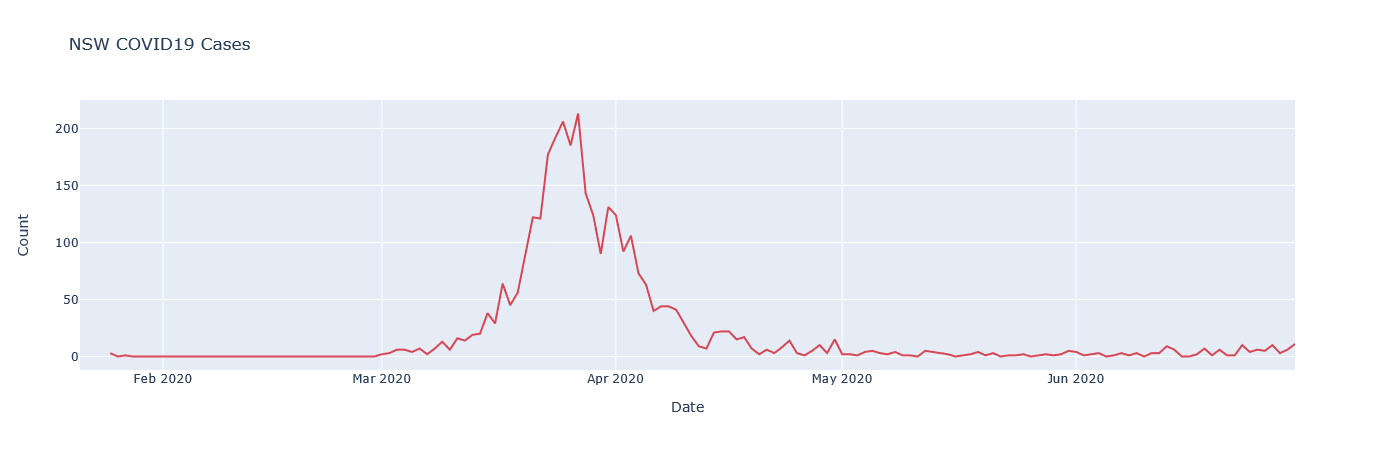

In [125]:
plot_dataset(df[df.index <'2020-07-01'], 'count', 'NSW COVID19 Cases')

## Preprocessing

In [196]:
def clean_text(text: str) -> str:
    cleaned = ' '.join(text.split())
    
    return cleaned

def add_noise(content: pd.Series) -> pd.Series:
    pass

def clean_all_text() -> pd.Series:
    pass

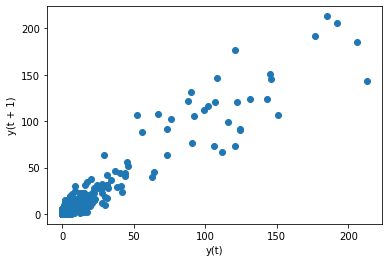

In [4]:
pd.plotting.lag_plot(df)
plt.show()

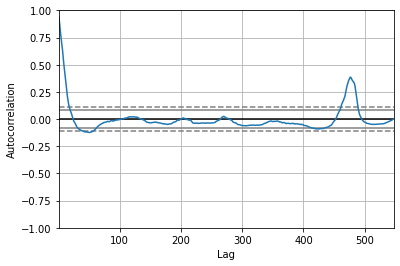

In [5]:
pd.plotting.autocorrelation_plot(df)
plt.show()

The only data we care about is the 

In [197]:
nsw_announcements = load_scraped()
nsw_announcements.head()

,content,source,theme,medium,date_released
date,,,,,
2020-01-21,NSW Health announced that it would assist\n ...,NSW Ministry of Health NSW Health advice to tr...,China,media release,21 January 2020.
2020-01-25,NSW Health released information that five\n ...,NSW Ministry of Health,Novel coronavirus statistics—11 am,media release,25 January 2020.
2020-02-06,NSW Health released a statement in\n ...,NSW Ministry of Health Be aware of the symptoms,be wary of false reports,media release,6 February 2020.
2020-02-10,The Minister for Health announced that a\n ...,B Hazzard (NSW Minister for Health),NSW researchers breakthrough on coronavirus,media release,10 February 2020.
2020-02-13,NSW Health released an update on the four\n ...,NSW Ministry of Health,Fourth coronavirus case in NSW now in the clear,media release,13 February 2020.


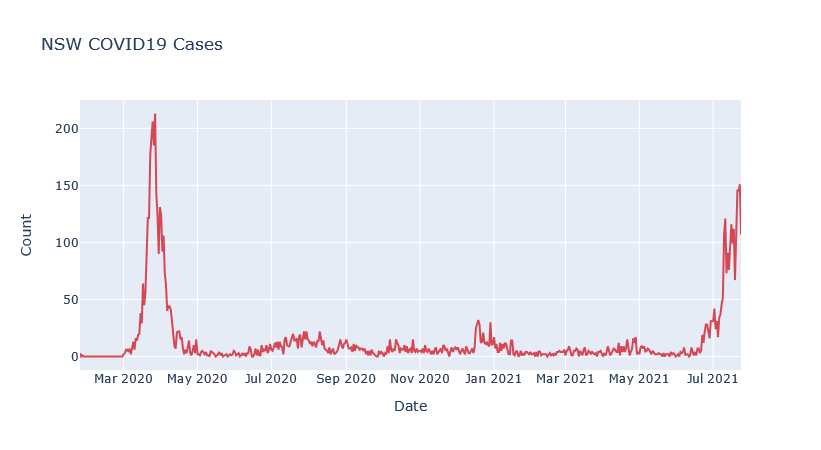

In [200]:
plot_dataset(df, 'NSW COVID19 Cases')

In [ ]:
[
    ['border_restriction', '2020-']
]

In [16]:
df[(df.index > '2020-01') & (df.index > '2020-')]

,count
date,
2020-01-25,3
2020-01-26,0
2020-01-27,1
2020-01-28,0
2020-01-29,0
...,...
2021-07-20,108
2021-07-21,146
2021-07-22,145


## 2. Transform

In [23]:
from abc import ABC, abstractmethod
from sklearn.preprocessing import MinMaxScaler

class TSTransformer(ABC):
    
    transformer_name = None
    transform_data_path = Path(f'data/transformed_{transformer_name}_data.csv')
        
    @abstractmethod
    def transform_data(self, ts_df: pd.DataFrame, input_dim: int = 0) -> pd.DataFrame:
        pass
    
    def load_transformed_data(self) -> pd.DataFrame:
        
        return pd.read_csv(self.transform_data_path, index_col='date')
    
    def generate_time_lags(self, df, n_lags):
        df_n = df.copy()
        for n in range(1, n_lags + 1):
            df_n[f'lag{n}'] = df_n['count'].shift(n)

        # Remove variables that are represented by the lag
        df_n = df_n.iloc[n_lags:]

        return df_n
    
    def scale_data(self, df, scaler) -> pd.DataFrame():
        df_ = df.copy()
        # TOOO:
        return df_
    
    
class MultiVariateTransformer(TSTransformer):
    
    def __init__(self):
        self.transformer_name = 'multivariate'
#     transform_data_path = Path(f'data/transformed_{self.transformer_name}_data.csv')

    def transform_data(self, ts_df: pd.DataFrame, input_dim: int = 0) -> pd.DataFrame:
        """Encapsulates the transformations done in preparation of the modelling"""
        
        df = ts_df.copy()
    
#         scaler = MinMaxScaler()
#         df = scaler.fit_transform(df)
        
        # Predict out 30 days
        df = self.generate_time_lags(df, 30)

        # Generate features from the date
        df_features = (
                    df
                    .assign(hour = df.index.hour)
                    .assign(day = df.index.day)
                    .assign(month = df.index.month)
                    .assign(day_of_week = df.index.dayofweek)
                    .assign(week_of_year = df.index.week)
                  )

        def onehot_encode_pd(df, col_name):
            """One hot encode the date features"""
            for col in col_name:
                df[col] = df[col].astype('object')
            dummies = pd.get_dummies(df[col_name], prefix=col_name)
            return pd.concat([df, dummies], axis=1).drop(col_name, axis=1)

        df.to_csv(self.transform_data_path)
        return df_features


class ARTransformer(TSTransformer):
    """Performs transformations for an autoregressive model. Particularly excludes extracting date data (day of week, week etc)"""
    def __init__(self):
        self.transformer_name = 'autoregressive'
#     self.transform_data_path = Path(f'data/transformed_{self.transformer_name}_data.csv')
        
    def transform_data(self, ts_df: pd.DataFrame, input_dim: int=0) -> pd.DataFrame:
        
        df_features = pd.DataFrame()
        
        return df_features

In [24]:
# transformer = MultiVariateTransformer()

transformer = MultiVariateTransformer()

df_transformed = transformer.transform_data(df, 100)
print(df_transformed.shape)
print(f'Date Coverage: {df_transformed.index.min()} - {df_transformed.index.max()}')

(517, 36)
Date Coverage: 2020-02-24 00:00:00 - 2021-07-24 00:00:00


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [151]:
# df_transformed[['count', 'lag100']].plot()

## 3. Model

### Prophet for a statistical approach

### Deep Learning because DL..

In [152]:
# plot_dataset(df, 'Daily COVID Cases In NSW')

### Split Data
We want to make predictions based on the most recent lockdown which started at approximately June 26th. We will try different splits

In [153]:
from sklearn.model_selection import train_test_split
from datetime import date

In [154]:
def split(df_tosplit: pd.DataFrame, target: str = 'count', split_on: date = None, test_ratio: float = .2) -> ():
    """Split data into train, test and validation using a date or ratio"""
    
    X = df_tosplit.copy()
    y = X.pop(target)
    
    val_ratio = .35#test_ratio / (1 - test_ratio)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    
    
    return X_train, X_test, X_val, y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = split(df_transformed)

In [155]:
# plot_dataset(y_train.to_frame(), "Training Data")

In [156]:
# plot_dataset(y_test.to_frame(), "Test Data")

In [157]:
# plot_dataset(y_val.to_frame(), "Validation Data")

# Checkpoint

In [159]:
# Save and load methods for processed data
def save_processed_files(X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr):
    """Save files to processed directory in a standard fashion"""
    processed_path = Path('data/processed')
    np.savetxt(processed_path / 'X_train.csv', X_train_arr, delimiter=',')
    np.savetxt(processed_path / 'X_val.csv', X_val_arr, delimiter=',')
    np.savetxt(processed_path / 'X_test.csv', X_test_arr, delimiter=',')

    np.savetxt(processed_path / 'y_train.csv', y_train_arr, delimiter=',')
    np.savetxt(processed_path / 'y_val.csv', y_val_arr, delimiter=',')
    np.savetxt(processed_path / 'y_test.csv', y_test_arr, delimiter=',')
    
save_processed_files(X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr)

In [160]:
def load_processed_files():
    """Load numpy arrays used to train models"""
    processed_path = Path('data/processed')
    
    print([p.name for p in processed_path.iterdir()])
    try:
        X_train_arr = np.loadtxt(processed_path / 'X_train.csv', delimiter=',')
        X_val_arr = np.loadtxt(processed_path / 'X_val.csv', delimiter=',')
        X_test_arr = np.loadtxt(processed_path / 'X_test.csv', delimiter=',')
        
        y_train_arr = np.loadtxt(processed_path / 'y_train.csv', delimiter=',')
        y_val_arr = np.loadtxt(processed_path / 'y_val.csv', delimiter=',')
        y_test_arr = np.loadtxt(processed_path / 'y_test.csv', delimiter=',')
    except Exception as e:
        print("Failed to load files, maybe doesn't exist?")
        print(e)
        
    return X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr

X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr = load_processed_files()

['y_train.csv', 'X_val.csv', 'y_test.csv', 'X_test.csv', 'y_val.csv', 'X_train.csv']


In [161]:
# Quick check to make sure they look correct
print(X_train_arr.shape, X_val_arr.shape, y_train_arr.shape)

(50, 455) (27, 455) (50,)


## Model 1: RNN

In [162]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [163]:
batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [164]:
class RNNModel(nn.Module):
    """Vanilla RNN Model"""
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        
        super(RNNModel, self).__init__()
        
        # Define number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # RNN Layers
        self.rnn = nn.RNN(
        input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        print(h0.shape)
        # Forward prop by passing input and hidden state into model
        out, h0 = self.rnn(x, h0.detach())
        
        # Reshape outputs into (batch_size, seq_length, hidden_size)
        out = out[:, -1, :]
        
        # Convert final state to output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [165]:
class LSTMModel(nn.Module):
    """LSTM Model"""
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [166]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [167]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [168]:
from datetime import datetime

In [169]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        # Set model to train mode
        self.model.train()
        
        # Predict
        yhat = self.model(x)
        
        # Compute loss
        loss = self.loss_fn(y, yhat)
        
        # Compute gradients
        loss.backward()
        
        # Update params and zero grads
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size: int = 64, n_epochs: int = 50, n_features: int = 1) -> None:
        """Trains the model in mini batches for n epochs"""
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        
        # Epoch Iteration
        for epoch in range(1, n_epochs+1):
            batch_losses = []
            
            # Mini Batch Iterations
            for x_batch, y_batch in train_loader:
                # Send tensors to device
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device) # TODO: setup device?
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
                
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            
            # Evaluation
            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                
            if (epoch <= 10) | (epoch %50 == 0):
                print(
                    f'[{epoch}/{n_epochs}] Training Loss: {training_loss:.4f}\t Validation Loss: {validation_loss:.4f}'
                )
            torch.save(self.model.state_dict(), model_path)
            
            
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            preds = []
            vals = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                
                self.model.eval()
                yhat = self.model(x_test)
                preds.append(yhat.to(device).detach().numpy())
                vals.append(y_test.to(device).detach().numpy())
                
        return preds, vals
                
        
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [170]:
import torch.optim as optim

In [171]:
len(X_train.columns), X_train_arr.shape[1]

(455, 455)

In [172]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



[1/100] Training Loss: nan	 Validation Loss: nan
[2/100] Training Loss: nan	 Validation Loss: nan
[3/100] Training Loss: nan	 Validation Loss: nan
[4/100] Training Loss: nan	 Validation Loss: nan
[5/100] Training Loss: nan	 Validation Loss: nan
[6/100] Training Loss: nan	 Validation Loss: nan
[7/100] Training Loss: nan	 Validation Loss: nan
[8/100] Training Loss: nan	 Validation Loss: nan
[9/100] Training Loss: nan	 Validation Loss: nan
[10/100] Training Loss: nan	 Validation Loss: nan
[50/100] Training Loss: nan	 Validation Loss: nan
[100/100] Training Loss: nan	 Validation Loss: nan


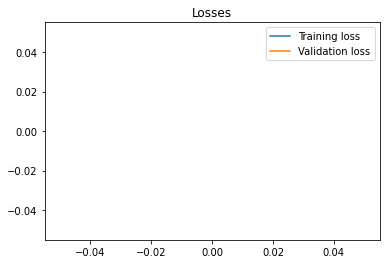

In [173]:
input_dim = X_train_arr.shape[1]
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {
    'input_dim': input_dim,
    'output_dim': output_dim,
    'layer_dim': layer_dim,
    'hidden_dim': hidden_dim,
    'dropout_prob': dropout
}

model = get_model('gru', model_params)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

opt = Optimization(model = model, loss_fn = loss_fn, optimizer = optimizer)
opt.train(train_loader, val_loader, batch_size = batch_size, n_epochs = n_epochs, n_features=input_dim)
opt.plot_losses()

preds, vals = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [174]:
def inverse_transform(scaler, df, columns):
    for c in columns:
        df[c] = scaler.inverse_transform(df[c])
    return df

def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    
    df_result = pd.DataFrame(data={'count': vals, 'prediction': preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [['count', 'prediction']])
    
    return df_result

df_result = format_predictions(preds, vals, X_test, scaler)

<AxesSubplot:xlabel='date'>

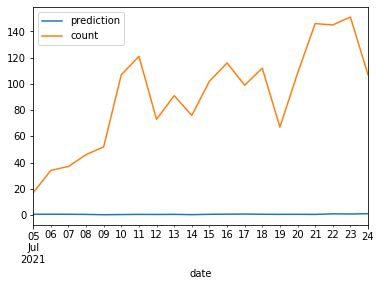

In [175]:
df_result[['prediction', 'count']].plot()

## Baseline

In [176]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df['count'], df.prediction.tolist()),
            'rmse' : mean_squared_error(df['count'], df.prediction) ** 0.5,
            'r2' : r2_score(df['count'], df.prediction)}

result_metrics = calculate_metrics(df_result)

In [177]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def build_baseline_model(df, test_ratio, target_col):
    df_ = df.copy()
    y = df_.pop('count') 
    X = df_
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )
    print(X_train)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["prediction"] = prediction
    result = result.sort_index()

    return result, model

df_baseline, model = build_baseline_model(df_transformed, 0.2, 'count')
baseline_metrics = calculate_metrics(df_baseline)


            lag1  lag2  lag3  lag4  lag5  lag6  lag7  lag8  lag9  lag10  ...  \
date                                                                     ...   
2021-04-19   9.0   4.0   9.0   1.0  12.0   4.0   4.0   6.0   7.0    5.0  ...   
2021-04-20   4.0   9.0   4.0   9.0   1.0  12.0   4.0   4.0   6.0    7.0  ...   
2021-04-21   7.0   4.0   9.0   4.0   9.0   1.0  12.0   4.0   4.0    6.0  ...   
2021-04-22  15.0   7.0   4.0   9.0   4.0   9.0   1.0  12.0   4.0    4.0  ...   
2021-04-23   5.0  15.0   7.0   4.0   9.0   4.0   9.0   1.0  12.0    4.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
2021-06-30  31.0  16.0  23.0  28.0  28.0  22.0  12.0  19.0   5.0    3.0  ...   
2021-07-01  31.0  31.0  16.0  23.0  28.0  28.0  22.0  12.0  19.0    5.0  ...   
2021-07-02  31.0  31.0  31.0  16.0  23.0  28.0  28.0  22.0  12.0   19.0  ...   
2021-07-03  42.0  31.0  31.0  31.0  16.0  23.0  28.0  28.0  22.0   12.0  ...   
2021-07-04  24.0  42.0  31.0  31.0  31.0

In [178]:
yhat_base = model.predict(df_transformed.drop(columns=['count']).to_numpy())

In [179]:
df_transformed['yhat_base'] = yhat_base

<AxesSubplot:xlabel='date'>

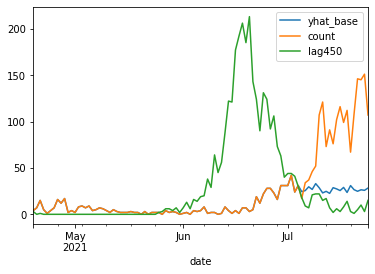

In [184]:
df_transformed[['yhat_base', 'count', 'lag450']].plot()

In [114]:
baseline_metrics

{'mae': 21.661610918256432,
 'rmse': 38.675494965810394,
 'r2': -0.1109192439858182}

# Deploy

In [ ]:
# from sagemaker.predictor import Predictor
# from sagemaker.serializers import JSONLinesSerializer
# from sagemaker.deserializers import JSONLinesDeserializer

# class SentimentPredictor(Predictor):
#     def __init__(self, endpoint_name, sagemaker_session):
#         super().__init__(
#             endpoint_name, 
#             sagemaker_session=sagemaker_session,
#             serializer=JSONLinesSerializer(),
#             deserializer=JSONLinesDeserializer()
#         )

# from sagemaker.pytorch.model import PyTorchModel

# pytorch_model_name = 'model-{}'.format(timestamp)

# model = PyTorchModel(name=pytorch_model_name,
#                      model_data='s3://dlai-practical-data-science/models/ab/variant_a/model.tar.gz',
#                      predictor_cls=SentimentPredictor,
#                      entry_point='inference.py',
#                      source_dir='src',
#                      framework_version='1.6.0',
#                      py_version='py3',
#                      role=role)

# pytorch_endpoint_name = 'endpoint-{}'.format(timestamp)

# predictor = model.deploy(initial_instance_count=1, 
#                          instance_type='ml.m5.large', 
#                          endpoint_name=pytorch_endpoint_name)